In [1]:
!rm -rf waymo-od > /dev/null
!git clone https://github.com/waymo-research/waymo-open-dataset.git waymo-od
!cd waymo-od && git branch -a
!cd waymo-od && git checkout remotes/origin/master
!pip3 install --upgrade pip

Cloning into 'waymo-od'...
remote: Enumerating objects: 2936, done.
remote: Counting objects: 100% (850/850), done.
remote: Compressing objects: 100% (314/314), done.
remote: Total 2936 (delta 620), reused 708 (delta 536), pack-reused 2086 (from 1)
Receiving objects: 100% (2936/2936), 96.57 MiB | 19.15 MiB/s, done.
Resolving deltas: 100% (2042/2042), done.
Updating files: 100% (390/390), done.
* master
  remotes/origin/HEAD -> origin/master
  remotes/origin/dependabot/pip/src/waymo_open_dataset/certifi-2023.7.22
  remotes/origin/dependabot/pip/src/waymo_open_dataset/certifi-2024.7.4
  remotes/origin/dependabot/pip/src/waymo_open_dataset/fonttools-4.43.0
  remotes/origin/dependabot/pip/src/waymo_open_dataset/grpcio-1.53.2
  remotes/origin/dependabot/pip/src/waymo_open_dataset/idna-3.7
  remotes/origin/dependabot/pip/src/waymo_open_dataset/pillow-10.3.0
  remotes/origin/dependabot/pip/src/waymo_open_dataset/pyarrow-14.0.1
  remotes/origin/dependabot/pip/src/waymo_open_dataset/requests-2.

In [2]:
!pip install waymo-open-dataset-tf-2-12-0==1.6.4
!pip install Pillow==9.2.0

In [3]:
import os
import tensorflow.compat.v1 as tf
import math
import numpy as np
import itertools

tf.enable_eager_execution()

from waymo_open_dataset.utils import range_image_utils, transform_utils, frame_utils
from waymo_open_dataset import dataset_pb2 as open_dataset


In [4]:
file_name = '/content/waymo-od/tutorial/frames'
waymo_df = tf.data.TFRecordDataset(file_name, compression_type='')
for data in waymo_df:
  frame = open_dataset.Frame()
  frame.ParseFromString(bytearray(data.numpy()))
  break

In [5]:
(range_images, camera_projections,
 _, range_image_top_pose) = frame_utils.parse_range_image_and_camera_projection(frame)

In [6]:
print(frame.context)

name: "11004685739714500220_2300_000_2320_000"
camera_calibrations {
  name: FRONT
  intrinsic: 2055.556149361639
  intrinsic: 2055.556149361639
  intrinsic: 939.6574698861468
  intrinsic: 641.0721821943271
  intrinsic: 0.03231600849798887
  intrinsic: -0.3214124825527059
  intrinsic: 0.0007932583953709973
  intrinsic: -0.0006257493541333847
  intrinsic: 0.0
  extrinsic {
    transform: 0.9998926849887427
    transform: -0.005993208400016058
    transform: 0.0133678704017097
    transform: 1.5389142447125008
    transform: 0.006042236521329663
    transform: 0.9999751560547995
    transform: -0.003630241176497072
    transform: -0.02363394083934774
    transform: -0.013345781499156929
    transform: 0.003710623431877962
    transform: 0.999904056092345
    transform: 2.115270572975561
    transform: 0.0
    transform: 0.0
    transform: 0.0
    transform: 1.0
  }
  width: 1920
  height: 1280
  rolling_shutter_direction: LEFT_TO_RIGHT
}
camera_calibrations {
  name: FRONT_LEFT
  intrins

In [7]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def show_camera_image(camera_image, camera_labels, layout, cmap = None):

#Display the camerage image and the given camera labels
  ax = plt.subplot(*layout)
  for camera_labels in frame.camera_labels:
    #Here the below code will ignore the camera labels that do not correspond to this camera
    if camera_labels.name != camera_image.name:
      continue

    for label in camera_labels.labels:
      #Bounding box
      ax.add_patch(patches.Rectangle(
          xy = (label.box.center_x-0.5*label.box.length,
                label.box.center_y-0.5*label.box.width),
          width=label.box.length,
          height=label.box.width,
          linewidth=1,
          edgecolor='red',
          facecolor='none'))

    #Display the camera image
  plt.imshow(tf.image.decode_jpeg(camera_image.image), cmap=cmap)
  plt.title(open_dataset.CameraName.Name.Name(camera_image.name), fontsize=20)
  plt.grid(False)
  plt.axis('off')

plt.figure(figsize=(25, 20))

for index, image in enumerate(frame.images):
  show_camera_image(image, frame.camera_labels, [3,3, index+1])




Output hidden; open in https://colab.research.google.com to view.

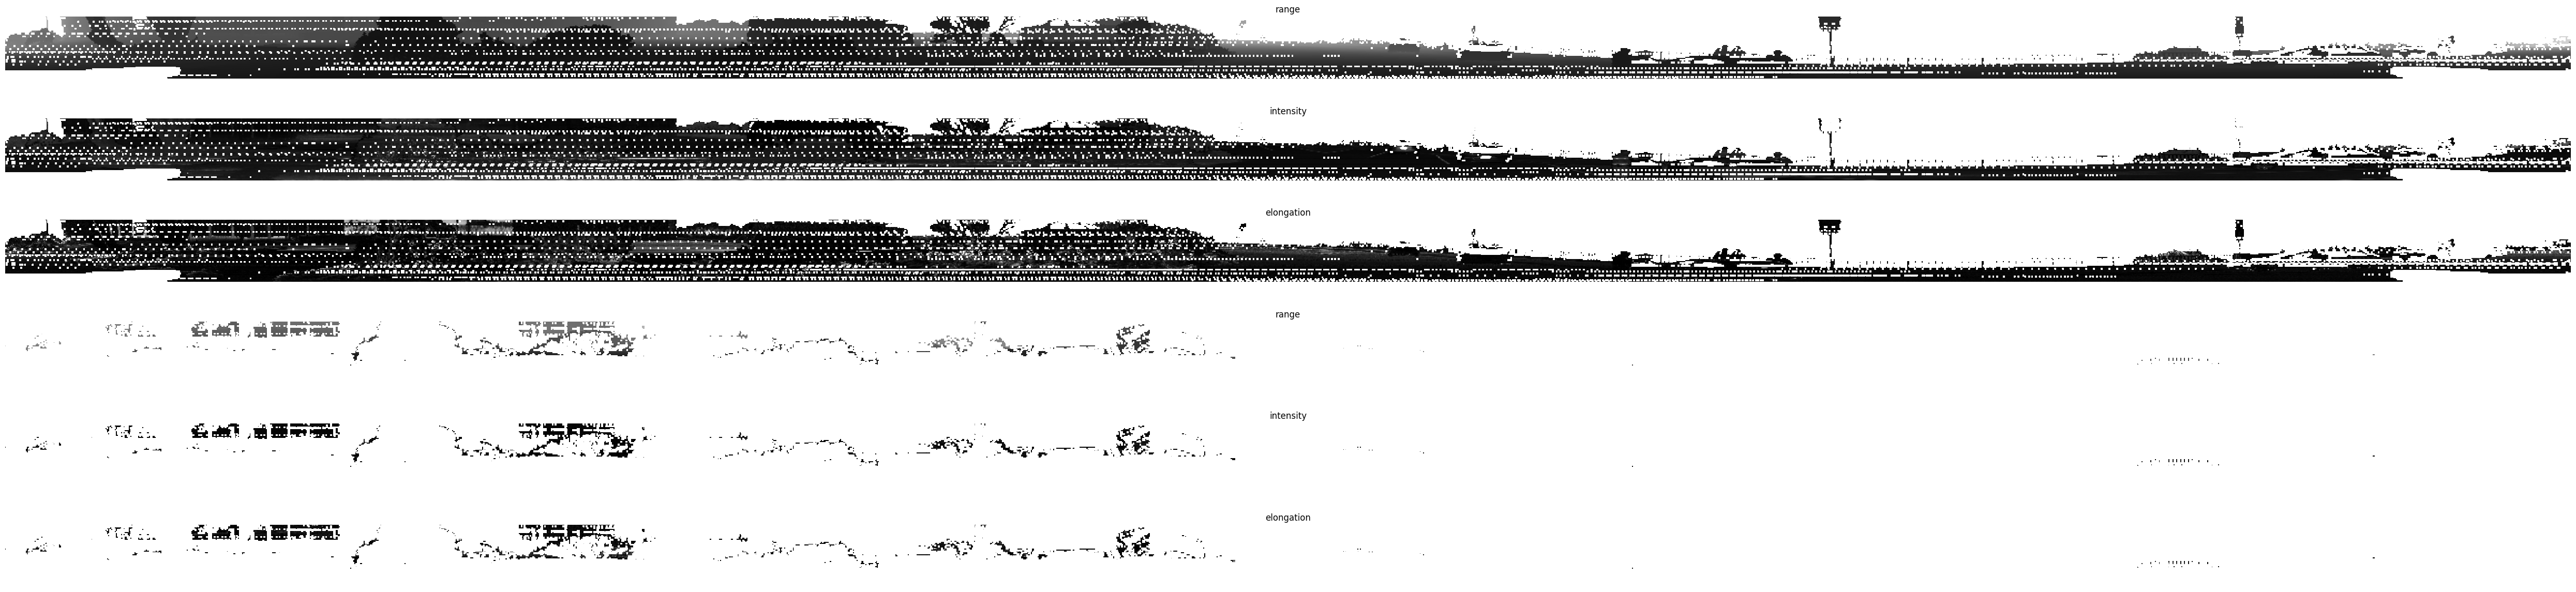

In [8]:
plt.figure(figsize=(64, 20))
def plot_range_image_helper(data, name, layout, vmin=0, vmax=1, cmap='gray'):
  plt.subplot(*layout)
  plt.imshow(data, cmap=cmap, vmin=vmin, vmax=vmax)
  plt.title(name)
  plt.grid(False)
  plt.axis('off')

def get_range_img(laser_name, return_index):
  #return range image with laser name and its return index
  return range_images[laser_name][return_index]

#Shows range image data from given lidar of type MatrixFloat
def show_range_image(range_image, layout_index_start = 1):
  range_image_tensor = tf.convert_to_tensor(range_image.data)
  range_image_tensor = tf.reshape(range_image_tensor, range_image.shape.dims)
  lidar_image_mask = tf.greater_equal(range_image_tensor, 0)
  range_image_tensor = tf.where(lidar_image_mask, range_image_tensor, tf.ones_like(range_image_tensor) * 1e10)
  range_image_range = range_image_tensor[...,0]
  range_image_intensity = range_image_tensor[...,1]
  range_image_elongation = range_image_tensor[...,2]
  plot_range_image_helper(range_image_range.numpy(), 'range',
                   [8, 1, layout_index_start], vmax=75, cmap='gray')
  plot_range_image_helper(range_image_intensity.numpy(), 'intensity',
                   [8, 1, layout_index_start + 1], vmax=1.5, cmap='gray')
  plot_range_image_helper(range_image_elongation.numpy(), 'elongation',
                   [8, 1, layout_index_start + 2], vmax=1.5, cmap='gray')
frame.lasers.sort(key=lambda laser: laser.name)
show_range_image(get_range_img(open_dataset.LaserName.TOP, 0), 1)
show_range_image(get_range_img(open_dataset.LaserName.TOP, 1), 4)

In [9]:
points, cp_points = frame_utils.convert_range_image_to_point_cloud(
    frame,
    range_images,
    camera_projections,
    range_image_top_pose)
points_ri2, cp_points_ri2 = frame_utils.convert_range_image_to_point_cloud(
    frame, range_images, camera_projections, range_image_top_pose, ri_index=1)

#3D points in the vehicle frame
points_all = np.concatenate(points, axis=0)
points_all_ri2 = np.concatenate(points_ri2, axis=0)
#camera projection corresponding to each point
cp_points_all = np.concatenate(cp_points, axis=0)
cp_points_all_ri2 = np.concatenate(cp_points_ri2, axis=0)

In [10]:
print(points_all.shape)
print(cp_points_all.shape)
print(points_all[0:2])
for i in range(5):
  print(points[i].shape)
  print(cp_points[i].shape)

(126059, 3)
(126059, 6)
[[-51.13867     5.100586    4.3288727]
 [-51.3291      5.243164    4.3369293]]
(108996, 3)
(108996, 6)
(3819, 3)
(3819, 6)
(4918, 3)
(4918, 6)
(3850, 3)
(3850, 6)
(4476, 3)
(4476, 6)


In [11]:
print(points_all_ri2.shape)
print(cp_points_all_ri2.shape)
print(points_all_ri2[0:2])
for i in range(5):
  print(points_ri2[i].shape)
  print(cp_points_ri2[i].shape)

(10104, 3)
(10104, 6)
[[-31.75293     6.5751953   3.5490723]
 [-15.777344    4.069336    2.8928528]]
(9868, 3)
(9868, 6)
(53, 3)
(53, 6)
(125, 3)
(125, 6)
(9, 3)
(9, 6)
(49, 3)
(49, 6)


In [12]:
images = sorted(frame.images, key=lambda i:i.name)
cp_points_all_concat = np.concatenate([cp_points_all, points_all], axis=-1)
cp_points_all_concat_tensor = tf.constant(cp_points_all_concat)

#Distance b/w lidar pts and vehicle frame origin
points_all_tensor = tf.norm(points_all, axis=-1, keepdims=True)
cp_points_all_tensor = tf.constant(cp_points_all, dtype=tf.int32)

mask = tf.equal(cp_points_all_tensor[...,0], images[0].name)

cp_points_all_tensor = tf.cast(tf.gather_nd(
    cp_points_all_tensor, tf.where(mask)), dtype=tf.float32)
points_all_tensor = tf.gather_nd(points_all_tensor, tf.where(mask))

projected_points_all_from_raw_data = tf.concat([cp_points_all_tensor[..., 1:3], points_all_tensor], axis=-1).numpy()

In [13]:
#To Generate color based range

def rgba(r):
  c = plt.get_cmap('jet')((r % 20.0) / 20.0)
  c = list(c)
  c[-1] = 0.5 #-->Alpha
  return c

def plot_image(camera_image):
  plt.figure(figsize=(20,12))
  plt.imshow(tf.image.decode_jpeg(camera_image.image))
  plt.grid("off")

def plot_points_on_image(projected_points, camera_image, rgba_func, point_size=5.0):
  plot_image(camera_image)
  xs = []
  ys = []
  colors = []

  for point in projected_points:
    xs.append(point[0])
    ys.append(point[1])
    colors.append(rgba_func(point[2]))

  plt.scatter(xs, ys, c=colors, s=point_size, edgecolors="none")

In [14]:
plot_points_on_image(projected_points_all_from_raw_data, images[0], rgba, point_size=5.0)

Output hidden; open in https://colab.research.google.com to view.

In [15]:
!pip install ultralytics

  Using cached matplotlib-3.9.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (11 kB)
Using cached matplotlib-3.9.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (8.3 MB)
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.6.1
    Uninstalling matplotlib-3.6.1:
      Successfully uninstalled matplotlib-3.6.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 1.22.0 requires numpy>=1.24.0, but you have numpy 1.23.0 which is incompatible.
bigframes 1.22.0 requires pyarrow>=10.0.1, but you have pyarrow 10.0.0 which is incompatible.
open3d 0.18.0 requires pillow>=9.3.0, but you have pillow 9.2.0 which is incompatible.
plotnine 0.13.6 requires pandas<3.0.0,>=2.1.0, but you have pandas 1.5.3 which is incompatible.
waymo-open-dataset-tf-2-12-0 1.6.4 requires matplotlib==3.6.1, but you have matplotl

In [16]:
import tensorflow as tf
from waymo_open_dataset import dataset_pb2 as open_dataset  # Waymo Open Dataset API
from PIL import Image
import io

FILENAME = '/content/waymo-od/tutorial/frames'
dataset = tf.data.TFRecordDataset(FILENAME, compression_type='')

#Iterate through Dataset
for data in dataset:
  #creating a frame object for the waymo dataset
  frame = open_dataset.Frame()
  #Parse the data from the record
  frame.ParseFromString(bytearray(data.numpy()))

  #Accessing and decoding images in the frame
  for camera_image in frame.images:
    print(f"Camera ID: {camera_image.name}")
    #Convert the raw bytes to image
    image = Image.open(io.BytesIO(camera_image.image))
    #Get shape of the image (width, height)
    width, height = image.size
    print(f"Image Shape: {width}x{height}")
    #image.show()

  #Laser Data - LIDAR
  for laser in frame.lasers:
    print(f"Laser Name: {laser.name}")

  break

Camera ID: 1
Image Shape: 1920x1280
Camera ID: 2
Image Shape: 1920x1280
Camera ID: 4
Image Shape: 1920x886
Camera ID: 3
Image Shape: 1920x1280
Camera ID: 5
Image Shape: 1920x886
Laser Name: 1
Laser Name: 2
Laser Name: 3
Laser Name: 4
Laser Name: 5


In [17]:
import numpy as np
import cv2

image_array = np.frombuffer(camera_image.image, np.uint8)
image = cv2.imdecode(image_array, cv2.IMREAD_COLOR)
print(f"Image Shape: {image.shape}")

Image Shape: (886, 1920, 3)


In [18]:
!pip install open3d

  Using cached pillow-11.0.0-cp310-cp310-manylinux_2_28_x86_64.whl.metadata (9.1 kB)
Using cached pillow-11.0.0-cp310-cp310-manylinux_2_28_x86_64.whl (4.4 MB)
  Attempting uninstall: pillow
    Found existing installation: Pillow 9.2.0
    Uninstalling Pillow-9.2.0:
      Successfully uninstalled Pillow-9.2.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
plotnine 0.13.6 requires pandas<3.0.0,>=2.1.0, but you have pandas 1.5.3 which is incompatible.
waymo-open-dataset-tf-2-12-0 1.6.4 requires matplotlib==3.6.1, but you have matplotlib 3.9.2 which is incompatible.
waymo-open-dataset-tf-2-12-0 1.6.4 requires pillow==9.2.0, but you have pillow 11.0.0 which is incompatible.


In [19]:
frames = []
#Iterate through Dataset
for data in dataset:
  #creating a frame object for the waymo dataset
  frame = open_dataset.Frame()
  #Parse the data from the record
  frame.ParseFromString(bytearray(data.numpy()))

  #Accessing and decoding images in the frame
  for camera_image in frame.images:
    image = Image.open(io.BytesIO(camera_image.image))
    image_cv = np.array(image)
    frames.append(image_cv)
  break

In [20]:
import torch

#Loading YOLOV5 model through this step
model = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True) #this has been pretrained on COCO Dataset

#Iterate through the frames extracted in above step
processed_frames = []
for frame in frames:
  #Run inference using YOLOV5
  results = model(frame)
  #In below step, Drawing a bounding boxes on the frame
  result_img = results.render() [0]
  #Converting back to OpenCV format for saving as video
  processed_frames.append(result_img)

/usr/local/lib/python3.10/dist-packages/torch/hub.py:295: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/ultralytics/yolov5/zipball/master" to /root/.cache/torch/hub/master.zip


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
requirements: Ultralytics requirements ['gitpython>=3.1.30', 'numpy>=1.23.5', 'setuptools>=70.0.0'] not found, attempting AutoUpdate...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.3/16.3 MB 181.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 438.3 MB/s eta 0:00:00
  Attempting uninstall: setuptools
    Found existing installation: setuptools 67.6.0
    Uninstalling setuptools-67.6.0:
      Successfully uninstalled setuptools-67.6.0
  Attempting uninstall: numpy
    Found existing installation: numpy 1.23.0
    Uninstalling numpy-1.23.0:
      Successfully uninstalled numpy-1.23.0

requirements: AutoUpdate success ✅ 9.0s, installed 3 packages: ['gitpyth

YOLOv5 🚀 2024-10-16 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla T4, 15102MiB)

100%|██████████| 14.1M/14.1M [00:00<00:00, 46.6MB/s]

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
WARNING ⚠️ NMS time limit 0.550s exceeded
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics

In [29]:
import cv2

output_file = 'output_video.mp4'
frame_height, frame_width, _ = processed_frames[0].shape
out = cv2.VideoWriter(output_file, cv2.VideoWriter_fourcc(*'mp4v'), 10, (frame_width, frame_height))

# Write each frame to the video file
for frame in processed_frames:
    out.write(frame)

# Release the video writer
out.release()

print(f"Video saved as {output_file}")

Video saved as output_video.mp4
